https://www.sfu.ca/~ssurjano/holder.html
https://www.sfu.ca/~ssurjano/crossit.html

In [452]:
import numpy as np
import random
import json

from typing import List, Tuple, Callable

import binary_utils as bu

In [453]:
with open('config.json', 'r') as f:
    config = json.load(f)

In [454]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def visualize_function(func, x_range=(-10, 10), y_range=(-10, 10), resolution=100, title="Function Visualization"):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros_like(X)
    for i in range(resolution):
        for j in range(resolution):
            Z[i, j] = func(X[i, j], Y[i, j])
    
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = fig.add_subplot(121)
    contour = ax1.contourf(X, Y, Z, 50, cmap='inferno')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title(f'{title} - Contour Plot')
    plt.colorbar(contour, ax=ax1)
    
    ax2 = fig.add_subplot(122, projection='3d')
    surface = ax2.plot_surface(X, Y, Z, cmap='inferno', 
                               linewidth=0, antialiased=True, alpha=0.8)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title(f'{title} - Surface Plot')
    
    plt.tight_layout()
    plt.show()

In [455]:
def cross_in_tray(x1: int, x2: int) -> int:
    term1 = np.sin(x1) * np.sin(x2)
    term2 = np.exp(abs(100 - np.sqrt(x1 ** 2 + x2 ** 2) / np.pi))

    return -0.0001 * (abs(term1 * term2) + 1) ** 0.1

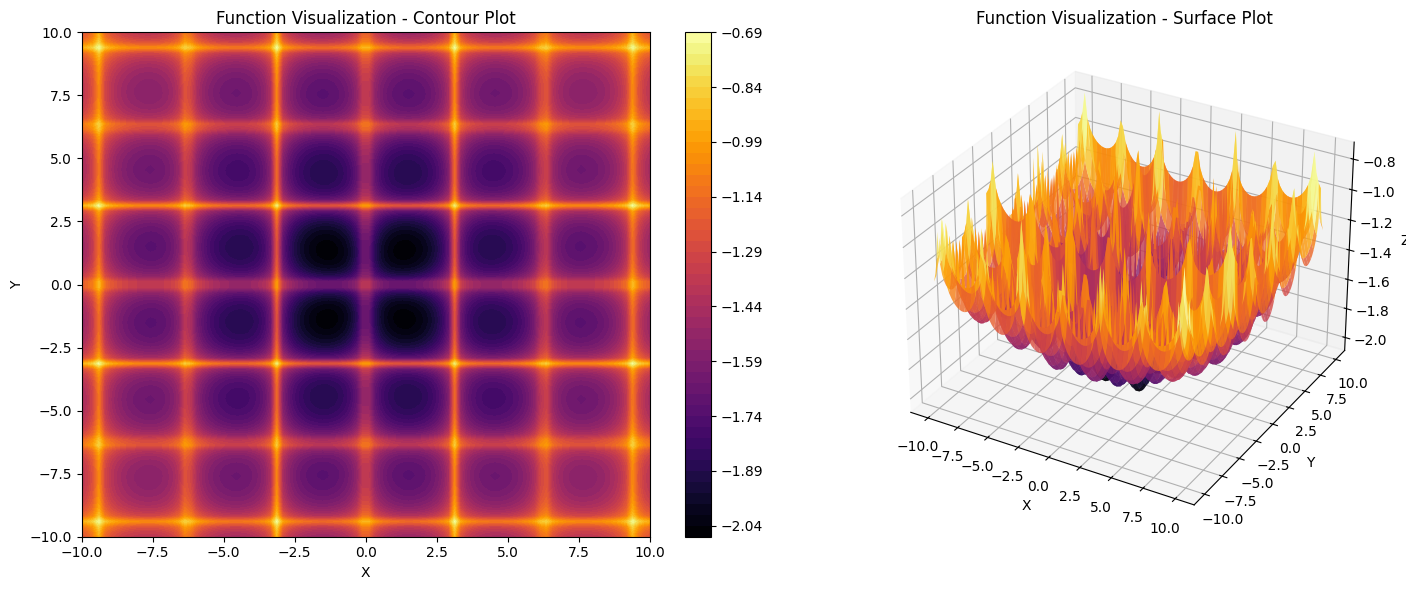

In [456]:
visualize_function(cross_in_tray)

In [457]:
def holder_table(x1: int, x2: int) -> int:
    term1 = np.sin(x1) * np.cos(x2)
    term2 = np.exp(abs(1 - (np.sqrt(x1 ** 2 + x2 ** 2)) / np.pi))

    return -1 * abs(term1 * term2)
    

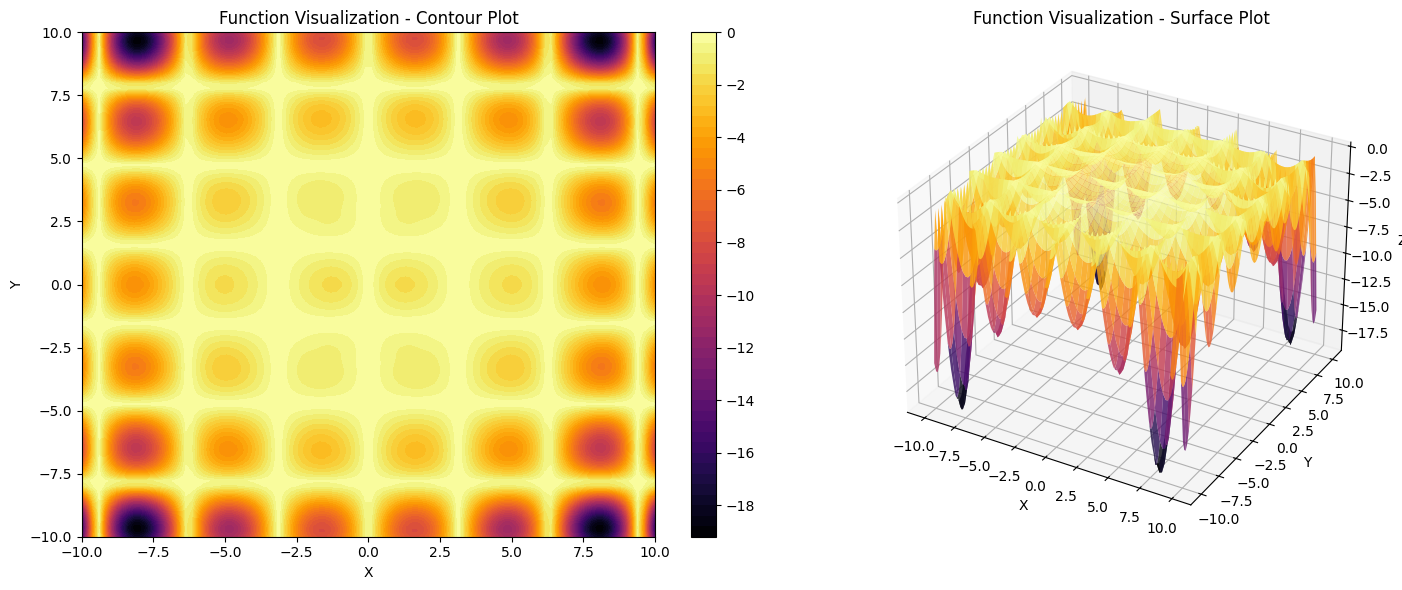

In [458]:
visualize_function(holder_table)

In [459]:
def fitness(individual: str, optimization_f: Callable) -> float:
    if isinstance(individual, str):
        x1, x2 = bu.decode(individual) 
    else:
        x1, x2 = individual
    
    return -1 * optimization_f(x1, x2)

In [460]:
def generate_initial_population(generate_f: Callable, optimization_f: Callable) -> List[dict]:
    population_size = config["population_size"]
    generation = []
    
    for _ in range(population_size):
        individual = generate_f()
        
        fitness_score = fitness(individual, optimization_f)
            
        generation.append({"genotype": individual, "score": fitness_score})
    return generation

In [461]:
def tournament_selection(population, tournament_size=3):
    tournament = random.sample(population, tournament_size)

    return max(tournament, key=lambda ind: ind["score"])

In [468]:
def find_minimum(optimization_f: Callable, crossover_f: Callable, mutation_f: Callable):
    population = generate_initial_population(bu.generate_binary_individual, optimization_f)

    print(f"Configuration: {config}")

    best_overall = max(population, key=lambda ind: ind["score"])

    generations = config["generations"]
    population_size = config["population_size"]
    crossover_rate = config["crossover_rate"]

    for gen in range(generations):
        new_population = []
        elite = max(population, key=lambda ind: ind["score"])
        new_population.append(elite)
        
        while len(new_population) < population_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            
            if random.random() < crossover_rate:
                child1_genotype, child2_genotype = crossover_f(parent1["genotype"], parent2["genotype"])
            else: 
                child1_genotype, child2_genotype = parent1["genotype"], parent2["genotype"]
                
            child1_genotype = mutation_f(child1_genotype)
            child2_genotype = mutation_f(child2_genotype)
            
            child1 = {"genotype": child1_genotype, "score": fitness(child1_genotype, optimization_f)}
            new_population.append(child1)
            
            if len(new_population) < population_size:
                child2 = {"genotype": child2_genotype, "score": fitness(child2_genotype, optimization_f)}
                new_population.append(child2)
                
        population = new_population
        
        current_best = max(population, key=lambda ind: ind["score"])
        if current_best["score"] > best_overall["score"]:
            best_overall = current_best
        
        if (gen + 1) % 10 == 0:
            best_x1, best_x2 = bu.decode(best_overall["genotype"])
            print(f"Generation {gen + 1}, Best score: {best_overall['score']:.6f}, x1 = {best_x1:.4f}, x2 = {best_x2:.4f}")
        
    best_x1, best_x2 = bu.decode(best_overall["genotype"])
    print(f"Score: {best_overall['score']:.10f}")
    print(f"x1 = {best_x1:.6f}, x2 = {best_x2:.6f}")
    print(f"genotype: {best_overall['genotype']}")

In [463]:
find_minimum(cross_in_tray, bu.one_point_crossover, bu.binary_mutation)

Configuration: {'mutation_rate': 0.1, 'crossover_rate': 0.8, 'population_size': 15, 'generations': 10, 'bits_per_input': 8}
Generation 10, Best score: 2.060967, x1 = 1.2941, x2 = 1.4510
Score: 2.0609674213
x1 = 1.294118, x2 = 1.450980
genotype: 1001001010010000


In [464]:
find_minimum(cross_in_tray, bu.two_point_crossover, bu.binary_mutation)

Configuration: {'mutation_rate': 0.1, 'crossover_rate': 0.8, 'population_size': 15, 'generations': 10, 'bits_per_input': 8}
Generation 10, Best score: 2.060351, x1 = 1.3725, x2 = -1.2157
Score: 2.0603514157
x1 = 1.372549, x2 = -1.215686
genotype: 0111000010010001


In [465]:
find_minimum(holder_table, bu.one_point_crossover, bu.binary_mutation)

Configuration: {'mutation_rate': 0.1, 'crossover_rate': 0.8, 'population_size': 15, 'generations': 10, 'bits_per_input': 8}
Generation 10, Best score: 19.117884, x1 = -7.9608, x2 = -9.6863
Score: 19.1178839024
x1 = -7.960784, x2 = -9.686275
genotype: 0000010000011010


In [466]:
find_minimum(holder_table, bu.two_point_crossover, bu.binary_mutation)

Configuration: {'mutation_rate': 0.1, 'crossover_rate': 0.8, 'population_size': 15, 'generations': 10, 'bits_per_input': 8}
Generation 10, Best score: 17.674569, x1 = 7.6471, x2 = 9.6863
Score: 17.6745689533
x1 = 7.647059, x2 = 9.686275
genotype: 1111101111100001
